# Analysing Glassdoor Reviews: Impact of Job Satisfaction on Employee Retention and Firm Performance in the IT Industry

The goal here is to create a **linear regression model** to help with the titular objective. We want to determine the impact of **job satisfaction** on:
1. **Employee retention**, and
2. **Firm performance**,
3. within the **IT industry** only.

Our data sources are **Glassdoor**, **Yahoo Finance** for retrieving measures of firm financial performance, and a **Ticker** dataset to match company names with their tickers, ensuring that financial data can be retrieved for the companies reviewed on Glassdoor. 

To achieve our goal, we'll follow these steps:
1. Scrape Glassdoor reviews
2. Clean Glassdoor data
3. Retrieve tickers of the **top public IT firms**, effectively restricting the scope to only companies within the IT Industry, and only those with publicly available financial data
4. Merge datasets
5. Clean merged data
6. Exploratory data analysis
7. Extract employee retention data from Glassdoor review data
8. Retrieve financial performance data
9. Convert data to numerical values where possible, and prepare final database for input to the linear regression model
10. Run the linear regression model and determine coefficients


## Step 1: Scrape Glassdoor reviews

Glassdoor reviews have been pre-scraped using selenium chromedriver. Here's an example of what we're scraping:

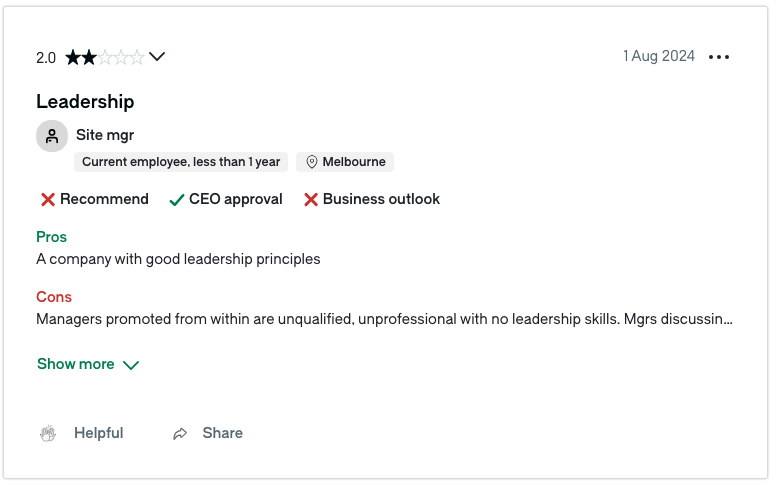

So, we might expect the following columns:
- overall rating
- title
- employee status
- recommend
- CEO approval
- business outlook
- pros
- cons
- date

and of course **company**. On top of that, each review also comes with category ratings:

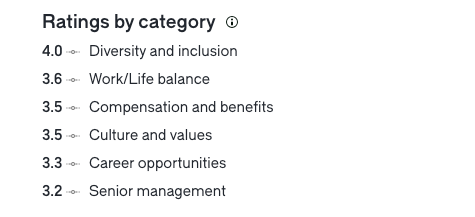

So we can expect those columns too. 

With the scraping complete, let's move to data inspection and cleaning.

## Step 2: Clean Glassdoor Data

First let's get a preview of the data.

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('all-reviews.csv', low_memory=False)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9901889 entries, 0 to 9901888
Data columns (total 19 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   rating                     float64
 1   title                      object 
 2   status                     object 
 3   pros                       object 
 4   cons                       object 
 5   advice                     object 
 6   Recommend                  object 
 7   CEO Approval               object 
 8   Business Outlook           object 
 9   Career Opportunities       object 
 10  Compensation and Benefits  object 
 11  Senior Management          object 
 12  Work/Life Balance          object 
 13  Culture & Values           float64
 14  Diversity & Inclusion      float64
 15  firm_link                  object 
 16  date                       object 
 17  job                        object 
 18  index                      float64
dtypes: float64(4), object(15)
memory usage: 1.

Nice. So we have **9,901,889** rows, 19 columns, and all the expected columns from the images above. Let's have a look at the data itself.

In [2]:
df.head(2)

,rating,title,status,pros,cons,advice,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,Diversity & Inclusion,firm_link,date,job,index
0,5.0,Good,"Current Employee, more than 10 years",Knowledge gain of complete project,Financial growth and personal growth,NaN,v,o,v,3,3,3,3,3.0,3.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Nov 19, 2022",Manager Design,NaN
1,4.0,Good,"Former Employee, less than 1 year","Good work,good work , flexible, support","Good,work, flexible,good support, good team work",NaN,v,o,o,4,4,4,4,4.0,4.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Jan 29, 2022",Anonymous Employee,NaN


Looks good. Things to note here:
- there's clearly some null data
- firm link doesn't actually contain the company, just some sort of URL
- there's a mismatch in typing between some of the numerical columns - integer vs float
- the company name will need to be extracted from the firm link
- the columns (Recommend, CEO Approval, Business Outlook) are represented by letters

This letter ratings are as follows:
- **v = Positive**
- **r = Mild**
- **x = Negative**
- **o = No opinion**

To actually work with these, we'll need to decide how to convert these accurately to a numerical scale later on.

For now, let's start cleaning the data.

In [3]:
print(df.isnull().sum())

rating                           171
title                          39424
status                           171
pros                             188
cons                             234
advice                       9901876
Recommend                        171
CEO Approval                     171
Business Outlook                 171
Career Opportunities         1848262
Compensation and Benefits    1878091
Senior Management            1975466
Work/Life Balance            1894490
Culture & Values             2246773
Diversity & Inclusion        6544282
firm_link                          0
date                             171
job                              171
index                        9740269
dtype: int64


Clearly there is a lot of missing data, so we have to decide what to do with it.

There are **9.9M+** rows, and the **'advice'** column is missing almost all of these, so we can drop that. 

Now, it looks like **Diversity & Inclusion** is missing more than half the rows, so it was probably introduced recently. Seeing as we have all the other measures, it won't impact our models too much if we drop it, and besides, it isn't a great measure of job satisfaction.

The **index** column seems to be unnecessary, so that can be dropped too.

In [4]:
df.drop(columns=['advice','index','Diversity & Inclusion'], inplace=True)

Great. From here, we need to decide how to deal with the remaining missing values. We shouldn't need to remove any more columns - the simplest solution will probably be to just remove all rows with missing values. If we do so we'll lose **2,246,773** rows due to the Nulls in Culture & Values, but given the huge dataset size that's not a bad tradeoff. Let's try it.

In [5]:
cleaned_df = df.dropna()
print(cleaned_df.isnull().sum())

rating                       0
title                        0
status                       0
pros                         0
cons                         0
Recommend                    0
CEO Approval                 0
Business Outlook             0
Career Opportunities         0
Compensation and Benefits    0
Senior Management            0
Work/Life Balance            0
Culture & Values             0
firm_link                    0
date                         0
job                          0
dtype: int64


No more Nulls. Let's take a look at our data now.

In [6]:
print(cleaned_df.shape)
cleaned_df.head(2)

(7488389, 16)


,rating,title,status,pros,cons,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,firm_link,date,job
0,5.0,Good,"Current Employee, more than 10 years",Knowledge gain of complete project,Financial growth and personal growth,v,o,v,3,3,3,3,3.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Nov 19, 2022",Manager Design
1,4.0,Good,"Former Employee, less than 1 year","Good work,good work , flexible, support","Good,work, flexible,good support, good team work",v,o,o,4,4,4,4,4.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Jan 29, 2022",Anonymous Employee


Great, we now have **7.4M+** rows of complete data. 

Next, we'll focus on merging this data with the top public IT firm Tickers - the reason being that this will cut out a lot more of the data, making future calculations simpler and faster. First thing we need to do is extract the firm name from the **firm_link** URL. Let's see:

### Converting firm_link to Company Name

First off, some examples to see what we're working with.

In [7]:
import re
import urllib.parse

print(cleaned_df.firm_link[1])
print(cleaned_df.firm_link[469])
print(cleaned_df.firm_link[1901])
print(cleaned_df.firm_link[5901])
print(cleaned_df.firm_link[99802])

Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm
https://www.glassdoor.com/Reviews/Canada-Life-Reviews-E23636.htm
Reviews/SS&C-Advent-Reviews-E646079.htm
https://www.glassdoor.com/Reviews/Boston-Red-Sox-Reviews-E5205.htm
Reviews/Chipotle-Reviews-E1370610.htm


With textual URL data like this, there can always be interesting UTF-8 character representations using the % sign. For example, accents can't be typed into URLs.

In [8]:
for index, firm_link in cleaned_df.firm_link.items():
    if "%" in firm_link:
        print(firm_link)
        print(index)
        break

https://www.glassdoor.com/Reviews/Universit%C3%A9-Toulouse-III-Paul-Sabatier-Reviews-E753896.htm
135445


A good example here with an accent. The urllib.parse library provides an easy way to convert these representations into the correct Unicode characters:

In [9]:
ctr = 0
for index, firm_link in cleaned_df['firm_link'].items():
    if "%" in firm_link:
        cleaned_df.at[index, 'firm_link'] = urllib.parse.unquote(firm_link)

In [10]:
print(cleaned_df.firm_link.loc[135445])

https://www.glassdoor.com/Reviews/Université-Toulouse-III-Paul-Sabatier-Reviews-E753896.htm


Looks like we've fixed it.

Next up, we need to extract the firm names. It's always after 'Reviews/' and before '-Reviews'. We'll use regex. To make things simpler, we'll also remove hyphens because the URL links add a hyphen between each word of the company. This is a significant change, but it also makes it easier to merge with the Ticker data.

In [11]:
cleaned_df = cleaned_df.rename(columns={'firm_link':'firm'})
cleaned_df['firm'] = cleaned_df['firm'].str.extract(r'(?<=Reviews\/)(.*)(?=-Reviews)')
cleaned_df['firm'] = cleaned_df['firm'].str.replace('-',' ', regex=False)
print(cleaned_df['firm'].head(2))
print(cleaned_df['firm'].tail(2))

0    Baja Steel and Fence
1    Baja Steel and Fence
Name: firm, dtype: object
9901887    Victoria Inn Hotel & Convention Centre
9901888    Victoria Inn Hotel & Convention Centre
Name: firm, dtype: object


Done. Ready to merge with the Ticker data by firm name.

## Step 3: Retrieve top public IT firm Tickers

We've retrieved a ticker dataset of the top public IT companies retrieved from https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/.

By merging this dataset with our own, we can very easily fetch financial data for each company being reviewed.

A good way to match Ticker to company name will be with some sort of fuzzy match / cosine similarity score.

In [12]:
tech_firm_tickers_df = pd.read_csv('tech-firms-by-market-cap.csv')
print(tech_firm_tickers_df.head(5))
print(tech_firm_tickers_df.shape, "\n")
print(tech_firm_tickers_df.isnull().sum())
tech_firm_tickers_df = tech_firm_tickers_df.dropna()
print("\n", tech_firm_tickers_df.shape)

   Rank               Name Symbol     marketcap  price (USD)        country
0     1          Microsoft   MSFT  3.073560e+12       413.54  United States
1     2              Apple   AAPL  2.786360e+12       181.71  United States
2     3             NVIDIA   NVDA  2.303500e+12       921.40  United States
3     4  Alphabet (Google)   GOOG  2.086900e+12       169.83  United States
4     5             Amazon   AMZN  1.963730e+12       188.70  United States
(952, 6) 

Rank           0
Name           0
Symbol         1
marketcap      0
price (USD)    0
country        0
dtype: int64

 (951, 6)


Interesting. So we have **951** companies in the Ticker dataset.

In [13]:
glassdoor_companies = pd.DataFrame(cleaned_df['firm'].unique(), columns=['Firm'])
print(glassdoor_companies.shape)

(31750, 1)


Meanwhile, we have **31,750** in the Glassdoor dataset. Let's hope we don't lose too much data in the merge.

Let's start with a simple equality match:

In [14]:
ctr = 0
for company1 in tech_firm_tickers_df['Name']:
    for company2 in glassdoor_companies['Firm']:
        if company1.lower() == company2.lower():
            ctr += 1
            break
print("%s matches on equality." % ctr)

211 matches on equality.


211 is not a lot - let's use a more advanced option. For more details, check out https://github.com/DeNederlandscheBank/name_matching.

In [15]:
from name_matching.name_matcher import NameMatcher

matcher = NameMatcher(top_n=500,
    number_of_rows=31750,
    lowercase=True,
    punctuations=True,
    remove_ascii=True,
    legal_suffixes=False,
    common_words=True,
    verbose=True)

In [16]:
matcher.load_and_process_master_data('Firm', glassdoor_companies)
matches = matcher.match_names(to_be_matched=tech_firm_tickers_df, column_matching='Name')

preprocessing...

preprocessing complete 
 searching for matches...



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


possible matches found   
 fuzzy matching...



100%|█████████████████████████████████████████| 951/951 [04:57<00:00,  3.20it/s]

done


In [17]:
print(matches.head(2))
print((matches['score'] == 0.0).sum().sum())
print((matches['score'] == 100.0).sum().sum())
print((matches['score'] >= 75.0).sum().sum())
print(matches.isnull().sum())

  original_name match_name  score  match_index
0     microsoft  microsoft  100.0         4708
1         apple      apple  100.0         9166
71
237
350
original_name    0
match_name       0
score            0
match_index      0
dtype: int64


Interesting. This time we got **350** company names with a matching score of greater than 75%, and **237** with a match of 100%. **This isn't great** - some of the companies with 75% may not be the same company at all, and there are many edge cases. As such, I've exported the matching data to clean the matches manually.

In [18]:
matches.to_csv('matches.csv', index=False)

I used this next section of code to help with my manual cleaning. I checked the number of reviews for companies that didn't sound familiar - if they had few reviews, I dropped them.

In [19]:
companies = cleaned_df['firm'].copy()
comp_counts = companies.value_counts()
comp_pcts = companies.value_counts(normalize=True)

checks = ['sohu', 'cognizant']


for company, count in comp_counts.items():
    for check in checks:
        if check in company.lower() and count > 50:
            print("{} reviews, {:.2f}%: {}".format(count, comp_pcts[company]*100, company))

64066 reviews, 0.86%: Cognizant Technology Solutions


I then saved the updated matches to a new file - **matches-updated.csv**. The match index hadn't changed, so I also added back the Ticker column from the top tickers dataset. If there wasn't a match, I left the column empty which would show up as Null. Let's have a look:

In [20]:
matches_updated = pd.read_csv('matches-updated.csv', low_memory=False)
print(matches_updated.head(2))
print(matches_updated.shape, "\n")
print(matches_updated.isnull().sum())
matches_updated = matches_updated.dropna()
print("\n", matches_updated.shape)

  match_name Symbol
0  microsoft   MSFT
1      apple   AAPL
(967, 2) 

match_name    651
Symbol          1
dtype: int64

 (316, 2)


Our number of matches: **318**. This isn't amazing but we'll see how many reviews we're left with. Given that the top public companies will have a significant majority of the reviews, this shouldn't cut out too much from the data - the main cut will come from reviews of companies outside the IT industry.

Next up: the merge.

## Step 4: Merge Datasets

Before merging, let's briefly prepare both datasets. We're dropping the 'index' column - this isn't needed any longer.

In [23]:
tickers_df = matches_updated.rename(columns={"match_name": "firm", "Symbol": "Ticker"})
tickers_df = tickers_df.reset_index(drop=True)
print(tickers_df.head(2))
cleaned_df['firm'] = cleaned_df['firm'].apply(lambda x: x.lower())
print(cleaned_df['firm'].head(2))

        firm Ticker
0  microsoft   MSFT
1      apple   AAPL
0    baja steel and fence
1    baja steel and fence
Name: firm, dtype: object


**Merge!**

In [24]:
merged_df = cleaned_df.merge(tickers_df, how='right')
print(merged_df.isnull().sum())
print(merged_df.shape)
merged_df = merged_df.dropna()

rating                       5
title                        5
status                       5
pros                         5
cons                         5
Recommend                    5
CEO Approval                 5
Business Outlook             5
Career Opportunities         5
Compensation and Benefits    5
Senior Management            5
Work/Life Balance            5
Culture & Values             5
firm                         0
date                         5
job                          5
Ticker                       0
dtype: int64
(1113068, 17)


Amazing, now we have a dataset of **1,152,488** Glassdoor reviews from 318 public IT companies complete with tickers. This is still a very solid amount of data to work with and we should be able to draw some meaningful analysis.

## Step 5: Clean and Transform Merged Data

Before we start analysing, let's clean and transform the merged data.

First, let's set all the numerical columns to integers. Let's have a look at the 'Senior Management' column.

In [25]:
merged_df['Senior Management'].value_counts().sort_values(ascending=False)

Senior Management
4      255316
3      238615
5      208025
1      136024
2      129718
4.0     37467
5.0     36974
3.0     31139
1.0     22258
2.0     17527
Name: count, dtype: int64

We have both ints and floats, which are clearly these are supposed to be the same type. Let's see which of the other numerical columns need to be fixed:

In [26]:
merged_df.dtypes

rating                       float64
title                         object
status                        object
pros                          object
cons                          object
Recommend                     object
CEO Approval                  object
Business Outlook              object
Career Opportunities          object
Compensation and Benefits     object
Senior Management             object
Work/Life Balance             object
Culture & Values             float64
firm                          object
date                          object
job                           object
Ticker                        object
dtype: object

Remember that Recommend, CEO Approval and Business Outlook are letters, which we'll handle momentarily.

Let's convert the other numericals to **floats**:

In [27]:
for col in ['Career Opportunities','Compensation and Benefits','Senior Management','Work/Life Balance']:
    merged_df[col] = merged_df[col].astype(float)
merged_df['Senior Management'].value_counts().sort_values(ascending=False)

Senior Management
4.0    292783
3.0    269754
5.0    244999
1.0    158282
2.0    147245
Name: count, dtype: int64

Much better. Next we need to decide how to deal with the letter ratings. As a reminder:
- **v = Positive**
- **r = Mild**
- **x = Negative**
- **o = No opinion**

In keeping with the scale of the other columns, let's encode these as follows:
- v = 5
- r = 0
- x = -5
- o = 0

Let's quickly check the uniques of each 'letter' column to make sure we're not missing anything.

In [28]:
print(merged_df['Recommend'].value_counts())
print(merged_df['CEO Approval'].value_counts())
print(merged_df['Business Outlook'].value_counts())

Recommend
v    709855
x    252466
o    150742
Name: count, dtype: int64
CEO Approval
v    560855
o    243125
r    197409
x    111674
Name: count, dtype: int64
Business Outlook
v    566586
o    207221
r    202310
x    136946
Name: count, dtype: int64


Great, now let's transform them.

In [29]:
for col in ['Recommend', 'CEO Approval', 'Business Outlook']:
    for letter, value in {'v':5.0, 'r':0.0, 'x':-5.0, 'o':0.0}.items():
        merged_df.loc[merged_df[col] == letter, col] = value
    merged_df[col] = merged_df[col].astype(float)

    print(merged_df[col].value_counts())

Recommend
 5.0    709855
-5.0    252466
 0.0    150742
Name: count, dtype: int64
CEO Approval
 5.0    560855
 0.0    440534
-5.0    111674
Name: count, dtype: int64
Business Outlook
 5.0    566586
 0.0    409531
-5.0    136946
Name: count, dtype: int64


**Sweet.** We can see from the value counts that everything has worked smoothly.

Now we'll want to transform the **date** column from String to DateTime, and extract the **year** and **quarter**. We'll be using the quarter to match the review dates with the financial data during the **linear regression**.

In [30]:
from datetime import datetime

merged_df['date'] = merged_df['date'].apply(lambda x: datetime.strptime(str(x).strip(' '), '%b %d, %Y'))
merged_df['year'] = merged_df['date'].dt.year
merged_df['quarter'] = pd.PeriodIndex(merged_df.date, freq='Q')
merged_df.head(2)

,rating,title,status,pros,cons,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,firm,date,job,Ticker,year,quarter
0,5.0,It was a good culture,Former Employee,- work from home -good culture -great benefits,-some managers shouldn't be managers,5.0,5.0,0.0,5.0,5.0,5.0,5.0,5.0,microsoft,2023-03-24,Customer Success Manager (CSM),MSFT,2023,2023Q1
1,5.0,Always-changing career and technology opportun...,"Current Employee, more than 10 years",Easy to make an impact on many people around t...,Extreme bureaucracy: random never-ending compl...,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,microsoft,2023-03-19,Principal Program Manager Lead,MSFT,2023,2023Q1


Awesome. Let's have a look at our column types now:

In [31]:
merged_df.dtypes

rating                              float64
title                                object
status                               object
pros                                 object
cons                                 object
Recommend                           float64
CEO Approval                        float64
Business Outlook                    float64
Career Opportunities                float64
Compensation and Benefits           float64
Senior Management                   float64
Work/Life Balance                   float64
Culture & Values                    float64
firm                                 object
date                         datetime64[ns]
job                                  object
Ticker                               object
year                                  int32
quarter                       period[Q-DEC]
dtype: object

Almost done. Last thing to do is to reorder the reviews by **date** and reupdate the index.

In [32]:
merged_df = merged_df.sort_values(by='date').reset_index(drop=True)
merged_df.head(2)

,rating,title,status,pros,cons,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,firm,date,job,Ticker,year,quarter
0,4.0,Great place to work,"Current Employee, more than 1 year",Very empowered environment. Pays well.,Make sure you are in the right team.,5.0,5.0,0.0,4.0,4.0,2.0,3.0,3.0,juniper networks,2012-05-22,Senior Software Engineer,JNPR,2012,2012Q2
1,2.0,good company to start with,"Former Employee, less than 1 year",good company to learn\r\n\r\nmysore good for t...,compensation is bad\r\n\r\nbad treatment to em...,-5.0,-5.0,-5.0,2.0,4.0,2.0,3.0,3.0,infosys,2012-05-23,Software Engineer,INFY.NS,2012,2012Q2


## Step 6: Exploratory Data Analysis

Now that we've cleaned and transformed the data, let's have a look at some statistics before merging with the financial data.

First, how many companies do we have?

In [52]:
print(merged_df['firm'].unique().shape)

(310,)


Next let's get an idea of the companies with the most reviews, i.e. more than **30,000**.

In [34]:
comp_counts = merged_df['firm'].value_counts()
over_30k = comp_counts[comp_counts > 30000]
comp_pcts = merged_df['firm'].value_counts(normalize=True)*100

for company, count in over_30k.items():
    print("{} reviews, {:.2f}%: {}".format(count, comp_pcts[company], company))

121747 reviews, 10.94%: amazon
64066 reviews, 5.76%: cognizant technology solutions
56224 reviews, 5.05%: accenture
51109 reviews, 4.59%: hp inc
43579 reviews, 3.92%: infosys
42191 reviews, 3.79%: ibm
37988 reviews, 3.41%: hcltech
36960 reviews, 3.32%: wipro
32830 reviews, 2.95%: oracle


Wow, Amazon makes up 10% of all our reviews. 

### That's pretty significant and worth considering - Amazon isn't necessarily a purely IT company, which may skew our results.

Let's graph that. We'll make the x axis more readable while we're at it.

In [35]:
print(over_30k.index)
over_30k = over_30k.set_axis(['Amazon','Oracle','Cognizant','Accenture','HP','InfoSys','IBM','HCLTech','WiPro'])
print(over_30k.index)

Index(['amazon', 'cognizant technology solutions', 'accenture', 'hp inc',
       'infosys', 'ibm', 'hcltech', 'wipro', 'oracle'],
      dtype='object', name='firm')
Index(['Amazon', 'Oracle', 'Cognizant', 'Accenture', 'HP', 'InfoSys', 'IBM',
       'HCLTech', 'WiPro'],
      dtype='object')


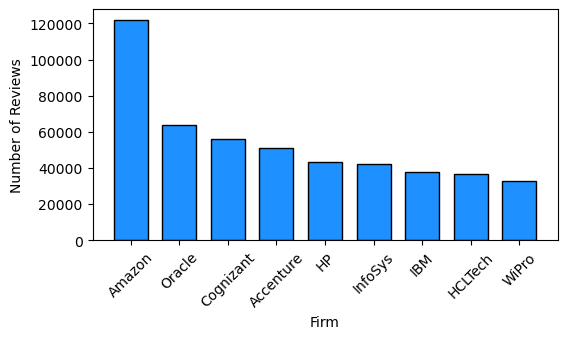

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.bar(over_30k.index.to_list(), height=over_30k, width=0.7, color='dodgerblue', edgecolor='black')
plt.xlabel('Firm')
plt.xticks(rotation=45)
plt.ylabel('Number of Reviews')
plt.show()

Let's create a review year histogram:

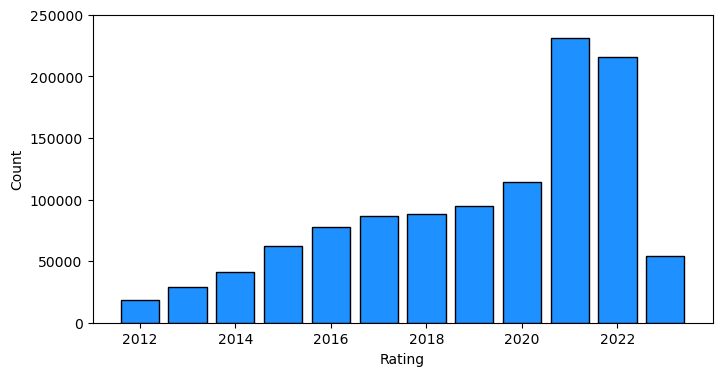

In [37]:
year_counts = merged_df['year'].value_counts(sort=False).sort_index().to_list()

x_labels = list(merged_df['year'].unique())

plt.figure(figsize=(8,4))
plt.bar(x_labels, height=year_counts, width=0.8, color='dodgerblue', edgecolor='black')
plt.ylim(top=250000)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

That's striking. A huge uptick in reviews from **2021-2022**. COVID-19?

Next, plotting the review star rating value counts:

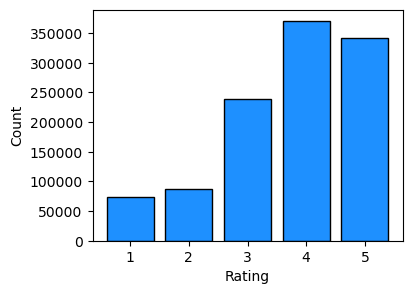

In [38]:
rating_counts = merged_df['rating'].value_counts(sort=False).sort_index().to_list()

plt.figure(figsize=(4,3))
plt.bar([1,2,3,4,5], height=rating_counts, width=0.8, color='dodgerblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Summary statistics for the Positive/Negative columns:

In [39]:
pos_neg_cols = ['Recommend', 'CEO Approval', 'Business Outlook']
pos_neg_stats = merged_df.describe()[pos_neg_cols]
pos_neg_stats = pos_neg_stats.drop(['count','min','25%','50%','75%','max'])
pos_neg_stats

,Recommend,CEO Approval,Business Outlook
mean,2.054641,2.017770,1.929990
std,4.170458,3.321744,3.475178


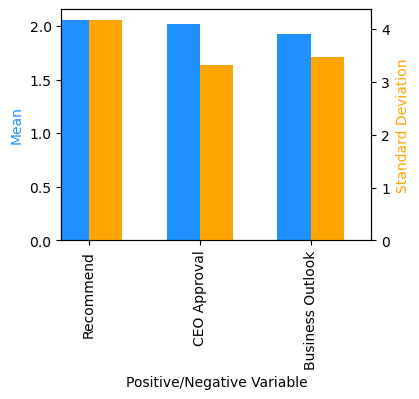

In [40]:
fig = plt.figure(figsize=(4,3))

ax = fig.add_subplot(111)
ax2 = ax.twinx()

pos_neg_stats.loc['mean'].plot(kind='bar', color='dodgerblue', ax=ax, width=0.3, position=1)
pos_neg_stats.loc['std'].plot(kind='bar', color='orange', ax=ax2, width=0.3, position=0)

ax.set_xlabel('Positive/Negative Variable')
ax.set_xticklabels(labels = pos_neg_cols)
ax.set_ylabel('Mean')
ax.yaxis.label.set_color('dodgerblue')
ax2.yaxis.label.set_color('orange')
ax2.set_ylabel('Standard Deviation')

plt.show()

The way to understand the above graph is that reviews generally recommended IT firms more positively than their business outlook.

In [41]:
job_sat_cols = ['Career Opportunities','Compensation and Benefits','Senior Management','Work/Life Balance','Culture & Values']

job_sat_stats = merged_df.describe()[job_sat_cols]
job_sat_stats = job_sat_stats.drop(['count','min','25%','50%','75%','max'])
job_sat_stats

,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values
mean,3.584047,3.524898,3.286571,3.603238,3.722472
std,1.226671,1.188516,1.327582,1.267993,1.279184


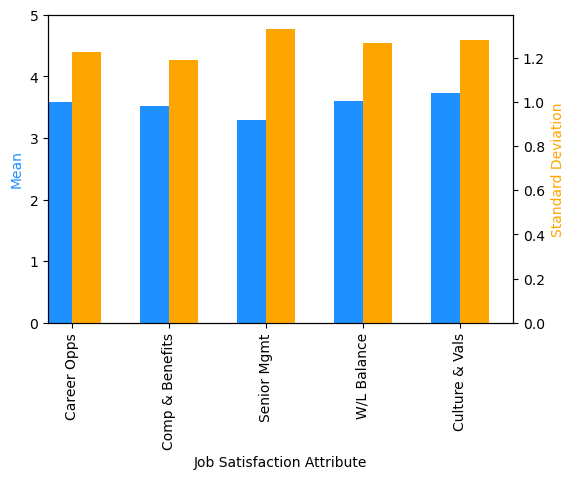

In [42]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(111)
ax2 = ax.twinx()

job_sat_stats.loc['mean'].plot(kind='bar', color='dodgerblue', ax=ax, width=0.3, position=1)
job_sat_stats.loc['std'].plot(kind='bar', color='orange', ax=ax2, width=0.3, position=0)

job_sat_labels = ['Career Opps','Comp & Benefits','Senior Mgmt','W/L Balance','Culture & Vals']

ax.set_xlabel('Job Satisfaction Attribute')
ax.set_xticklabels(labels = job_sat_labels)
ax.set_ylabel('Mean')
ax.set_ylim(top=5)
ax.yaxis.label.set_color('dodgerblue')
ax2.yaxis.label.set_color('orange')
ax2.set_ylabel('Standard Deviation')

plt.show()

Very interesting. People tend to rate **Culture & Values** the **highest**, and **Senior Management** the **lowest**. Notably, Senior Management also **varies the most** - people tend to either love or hate upper management in the IT industry.

With the exploratory data analysis complete, let's extract our final feature - employee retention.

## Step 7: Extract employee retention data from Glassdoor review data

Every review also has a **status** value, which indicates whether the employee is a current or former employee. We can use this to determine retention/turnover. In keeping with the theme of 5:
- **Retention = 5.0**
- **Turnover = -5.0**

That way when we're predicting retention/turnover, predictions > 0 are classified as retention and < 0 as turnover.

In [43]:
print(merged_df['status'].unique())

['Current Employee, more than 1 year' 'Former Employee, less than 1 year'
 'Current Employee, less than 1 year'
 'Current Employee, more than 5 years' 'Current Employee'
 'Current Employee, more than 3 years' 'Former Employee, more than 1 year'
 'Current Employee, more than 10 years'
 'Former Employee, more than 3 years'
 'Former Employee, more than 10 years' 'Former Employee'
 'Current Employee, more than 8 years'
 'Former Employee, more than 5 years' 'Former Employee, more than 8 years'
 'Current Freelancer' 'Current Intern, less than 1 year'
 'Former Intern, less than 1 year' 'Former Contractor, less than 1 year'
 'Former Freelancer, more than 3 years' 'Current Contractor'
 'Current Freelancer, more than 8 years']


There are many uniques, but they all share a commonality, they either start with **Current** or **Former**. That makes our job easy:

In [44]:
merged_df['status'] = merged_df['status'].str.split(' ').str[0]
print(merged_df['status'].unique())

for retention, value in {'Current':5.0, 'Former':-5.0}.items():
    merged_df.loc[merged_df['status'] == retention, 'status'] = value
merged_df['status'] = merged_df['status'].astype(float)

print(merged_df['status'].value_counts())

['Current' 'Former']
status
 5.0    736517
-5.0    376546
Name: count, dtype: int64


**Done**. Ready for regression analysis. Next up - retrieving financial data.

## Step 8: Retrieve financial performance data

Great, now the next step is to retrieve financials for each company. We'll need to choose what exactly we want to use as our measure of financial performance. This is a highly debated topic in finance, so we just want to choose something simple. Some ideas:
- **EPS**
- **Market Capitalisation (MCAP)**
- **Total Revenue**
- **Return on Assets (ROA)**

Let's choose **MCAP** and **ROA**. We'll go into more detail later, but market cap is a great general indicator of firm size but is strongly influenced by market fluctuations, while return on assets is much less exposed to market fluctuations while still accounting for both **tangible** and **intangible assets**. This makes sense for our analysis, given that the output of productive employees is not always tangible.

Let's try first with **Yahoo Finance**.

## Attempt 1: Yahoo Finance (not necessarily relevant, feel free to skip to Attempt 2)

In [45]:
financials = ['industry']

In [46]:
import yfinance as yf
import requests

stock = yf.Ticker('AAPL')
financials = ['trailingEps','marketCap','totalRevenue','returnOnAssets']

print(f"{stock.info['shortName']} ({stock.info['symbol']})")
for financial in financials:
    print(f"{financial}: {stock.info[financial]}")

Apple Inc. (AAPL)
trailingEps: 6.57
marketCap: 3442208145408
totalRevenue: 385603010560
returnOnAssets: 0.22612


These are current values... let's see if we can get AAPL's EPS in Q1 2018 as an example:

In [47]:
print(stock.financials.loc['Diluted EPS'])
print(stock.financials.loc['Basic EPS'])
print(stock.quarterly_income_stmt.loc['Diluted EPS'])
print(stock.quarterly_income_stmt.loc['Basic EPS'])

2023-09-30    6.13
2022-09-30    6.11
2021-09-30    5.61
2020-09-30    3.28
Name: Diluted EPS, dtype: object
2023-09-30    6.16
2022-09-30    6.15
2021-09-30    5.67
2020-09-30    3.31
Name: Basic EPS, dtype: object
2024-06-30     1.4
2024-03-31    1.53
2023-12-31    2.18
2023-09-30    1.46
2023-06-30    1.26
2023-03-31     NaN
2022-12-31     NaN
Name: Diluted EPS, dtype: object
2024-06-30     1.4
2024-03-31    1.53
2023-12-31    2.19
2023-09-30    1.47
2023-06-30    1.27
2023-03-31     NaN
2022-12-31     NaN
Name: Basic EPS, dtype: object


No luck... the data only goes back either 4 years or 5 quarters.

In [48]:
stock.get_earnings_dates(limit=20)

,EPS Estimate,Reported EPS,Surprise(%)
Earnings Date,,,
2025-07-30 06:00:00-04:00,NaN,NaN,NaN
2025-04-30 06:00:00-04:00,NaN,NaN,NaN
2025-01-30 16:00:00-05:00,NaN,NaN,NaN
2024-10-31 06:00:00-04:00,1.59,NaN,NaN
2024-08-01 16:00:00-04:00,1.35,1.40,0.0399
2024-05-02 16:00:00-04:00,1.50,1.53,0.0197
2024-02-01 16:00:00-05:00,2.10,2.18,0.0390
2023-11-02 16:00:00-04:00,1.39,1.46,0.0492
2023-08-03 16:00:00-04:00,1.19,1.26,0.0549


EPS is the only measure we can get a hold of. Unfortunately this isn't enough for our analysis. Let's try a different option.

## Attempt 2: CRSP/Compustat Merged financial database

This database requires institutional access. Register for the service at https://wrds-www.wharton.upenn.edu/register/.

The CRSP/Compustat Merged database is very large and very in-depth compared to most. It allows for almost unlimited customisation in queries, so we need to be specific in the data we want.

As a reminder, we need our financial data in **quarterly form**, which we will match up with the reviews that are posted in that quarter. The first and last dates/quarters of our reviews are as follows:

In [49]:
print(merged_df['date'].head(1).iloc[0])
print(merged_df['date'].tail(1).iloc[0])
print(merged_df['quarter'].head(1).iloc[0])
print(merged_df['quarter'].tail(1).iloc[0])

2012-05-22 00:00:00
2023-07-10 00:00:00
2012Q2
2023Q3


So, our query is as follows. We want the:
- **market cap**, and
- **return on assets**,
- for every unique ticker in our database,
- from **Q2 2012** to **Q3 2023**.

CRSP allows for a **.txt** file of each of the ticker names separated by a line to be used as input. Let's generate that:

In [54]:
with open('unique_tickers.txt', 'w') as file:
    for ticker in merged_df['Ticker'].unique():
        file.write(f"{ticker}\n")

Great. Now let's run the query above with the **unique_tickers.txt** file to the query builder at https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/crspcompustat-merged/fundamentals-quarterly. 

Note that we are searching in the **Fundamentals Quarterly** section of the database.

### TODO: the Compustat database doesn't return results for companies outside north america, I think. I.e. any ticker that is a number.